In [146]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pprint
import onnxmltools.convert.lightgbm.convert
from skl2onnx.common.data_types import FloatTensorType
from onnxmltools.utils import save_model
import onnxruntime as rt

In [147]:
df = pd.read_csv("..\OMLT_ML\data\polynomial3.csv")
df.head()

,theta,z,u
0,-20.0,-6.08,-3.92
1,-19.5,-5.58,-4.42
2,-19.1,-5.13,-4.87
3,-18.6,-4.71,-5.29
4,-18.1,-4.32,-5.68


In [148]:
X = df["theta"]
y = df["z"]

# X = X.reset_index(drop = True)
# y = y.reset_index(drop = True)

X = X.to_numpy().reshape(-1, 1)
y = y.to_numpy().reshape(-1, 1)

X.shape, y.shape

((180, 1), (180, 1))

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data_linear = lgb.Dataset(X_train, label=y_train)

train_data_normal = lgb.Dataset(X_train, label=y_train)

In [150]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 1,
    # "verbosity": 2, # full log
    "verbosity": -1,
    # 'linear_tree': True,
    'num_iterations': 5,
}

model_linear = lgb.train(params, train_data_linear)

c:\Users\shumengl\.conda\envs\omlt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\shumengl\.conda\envs\omlt\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [151]:
y_pred_linear = model_linear.predict(X_test)
print(f"Linear trees error: {round(mean_squared_error(y_test, y_pred_linear),3)}")
y_linear = model_linear.predict(X)

Linear trees error: 1.379


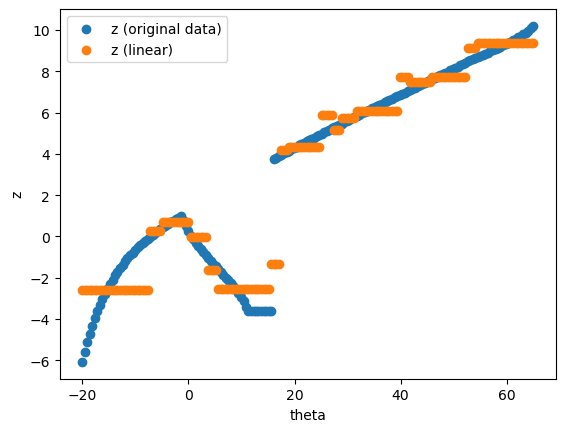

In [152]:
# plotting results
plt.scatter(X, y, label = 'z (original data)')
plt.scatter(X, y_linear, label = 'z (linear)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()

In [153]:
print(model_linear.params)

{'objective': 'regression', 'metric': 'rmse', 'learning_rate': 1, 'verbosity': -1, 'num_iterations': 5, 'early_stopping_round': None}


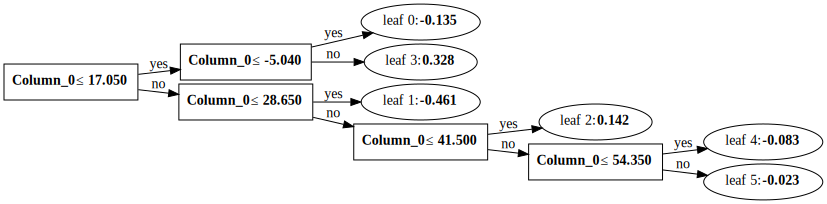

In [154]:
# extra step to allow graphviz to be found 
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
p = lgb.create_tree_digraph(model_linear, params['num_iterations']-1)
p

In [155]:
model_linear.save_model('model.txt')

In [156]:
initial_type = [('float_input', FloatTensorType([None, 1]))]
onx = onnxmltools.convert.lightgbm.convert(model_linear, initial_types=initial_type)
save_model(onx, "model_linear.onnx")

The maximum opset needed by this model is only 8.


In [157]:
sess = rt.InferenceSession("model_linear.onnx")
input_name = sess.get_inputs()[0].name
print("input name", input_name)
input_shape = sess.get_inputs()[0].shape
print("input shape", input_shape)
input_type = sess.get_inputs()[0].type
print("input type", input_type)
output_name = sess.get_outputs()[0].name
print("output name", output_name)
output_shape = sess.get_outputs()[0].shape
print("output shape", output_shape)
output_type = sess.get_outputs()[0].type
print("output type", output_type)

input name float_input
input shape [None, 1]
input type tensor(float)
output name variable
output shape [None, 1]
output type tensor(float)


In [159]:
pred_onx = sess.run([output_name], {input_name: X.astype(np.float32)})
# pred_onx

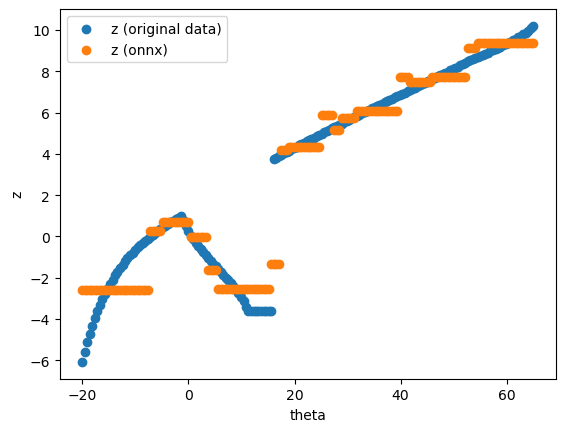

In [160]:
# plotting results
plt.scatter(X, y, label = 'z (original data)')
plt.scatter(X, pred_onx, label = 'z (onnx)')
plt.ylabel('z')
plt.xlabel('theta')
plt.legend()
plt.show()